# LSTM

In [1]:
# Environment variables
from dotenv import load_dotenv
load_dotenv("../mysql.env")

import os
import sys
import mysql.connector

import numpy as np 
import pandas as pd
import math
import time
import random
import matplotlib.pyplot as plt

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# List of Stocks and ETFs
Provided by Thomas Choi.

In [11]:
stock_list = pd.read_csv("../stocks_and_etfs/stock_list.csv")
etf_list = pd.read_csv("../stocks_and_etfs/etf_list.csv")

In [125]:
# Choose a random stock
stock_symbol = random.choice(stock_list.iloc[:,0])
print(stock_symbol)

CMCSA


## MySQL connection
Choosing one stock from SQL query to reduce query time.

In [126]:
HOST=os.environ.get("HOST")
PORT=os.environ.get("PORT")
USER=os.environ.get("USER")
PASSWORD=os.environ.get("PASSWORD")

try: 
    conn = mysql.connector.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database="GlobalMarketData"
    )
    query = f"SELECT Date, Close, Open, High, Low, Volume from histdailyprice3 WHERE Symbol='{stock_symbol}';"
    histdailyprice3 = pd.read_sql(query, conn)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

In [92]:
df = histdailyprice3.copy()
stock_prices = df.Close.values.astype('float32')
stock_prices = stock_prices.reshape(len(stock_prices), 1)
stock_prices.shape

(6147, 1)

# Feature Scaling

In [93]:
scaler = MinMaxScaler(feature_range=(0, 1))
stock_prices = scaler.fit_transform(stock_prices)

# Test Train Split

In [94]:
train_size = int(len(stock_prices) * 0.80)
test_size = len(stock_prices) - train_size
train, test = stock_prices[0:train_size,:], stock_prices[train_size:len(stock_prices),:]
print("Train:", len(train), "Test:", len(test))

Train: 4917 Test: 1230


In [95]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [96]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [97]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Build Model

In [98]:
model = Sequential()

# add first layer with dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(train.shape[1],1)))
model.add(Dropout(0.2))

# add second layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# add third layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# add fourth layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# the output layer
model.add(Dense(units=1))

# Compile Model

In [99]:
start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.004593849182128906


# Fit Model

In [100]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    epochs=10,
    validation_split=0.05)

Epoch 1/10
37/37 [==============================] - 8s 28ms/step - loss: 9.1529e-04 - val_loss: 0.0071
Epoch 2/10
37/37 [==============================] - 0s 8ms/step - loss: 6.7389e-04 - val_loss: 0.0050
Epoch 3/10
37/37 [==============================] - 0s 7ms/step - loss: 5.8550e-04 - val_loss: 0.0035
Epoch 4/10
37/37 [==============================] - 0s 7ms/step - loss: 2.7674e-04 - val_loss: 3.6640e-04
Epoch 5/10
37/37 [==============================] - 0s 8ms/step - loss: 9.5089e-05 - val_loss: 7.9887e-04
Epoch 6/10
37/37 [==============================] - 0s 7ms/step - loss: 9.7174e-05 - val_loss: 2.2437e-04
Epoch 7/10
37/37 [==============================] - 0s 7ms/step - loss: 7.8988e-05 - val_loss: 1.5638e-05
Epoch 8/10
37/37 [==============================] - 0s 7ms/step - loss: 7.7671e-05 - val_loss: 1.5777e-04
Epoch 9/10
37/37 [==============================] - 0s 7ms/step - loss: 7.0550e-05 - val_loss: 1.4585e-05
Epoch 10/10
37/37 [==============================] - 0s 7

# Prediction

In [101]:
predicted = model.predict(testX)
predicted = scaler.inverse_transform(predicted)

In [110]:
real = scaler.inverse_transform(testY.reshape(-1,1))

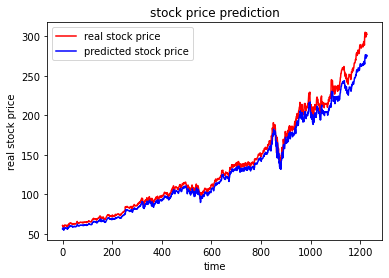

In [111]:
# visualizing the results: predicted vs test
plt.plot(real, color="red", label="real stock price")
plt.plot(predicted, color="blue", label="predicted stock price")
plt.title("stock price prediction")
plt.xlabel("time")
plt.ylabel("real stock price")
plt.legend()
plt.show()

In [112]:
# function which calculates root mean squared error
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

In [113]:
return_rmse(real, predicted)

the root mean squared error is : 8.979781859197335.


# Evaluation

In [ ]:
#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                   
    return rmse

def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

In [ ]:
def calculate_perf_metrics(var, logNeptune=True, logmodelName='Simple MA'):
    ### RMSE 
    rmse = calculate_rmse(np.array(stockprices[train_size:]['Close']), np.array(stockprices[train_size:][var]))
    ### MAPE 
    mape = calculate_mape(np.array(stockprices[train_size:]['Close']), np.array(stockprices[train_size:][var]))
    
    if logNeptune:        
        npt_exp.send_metric('RMSE', rmse)
        npt_exp.log_metric('RMSE', rmse)
        
        npt_exp.send_metric('MAPE (%)', mape)
        npt_exp.log_metric('MAPE (%)', mape)
    
    return rmse, mape

In [ ]:
parameters = {
    
}